# Solve Any Data Analysis Problem

## Chapter 2 - Example project: Where are your customers based?

# Goals

The research question is to calculate customer spend by city, and use this data to compare London with the rest of the UK.

- **explore** the customer address data
- **come up with a method** to extract the city from the address field
- **calculate** total spend per city
- **analyze** results to understand the spending of London customers vs. those outside London

### Final output

A dataset containing one row per city and the corresponding total customer spend.

In [1]:
import pandas as pd

In [2]:
customers = pd.read_csv("./data/addresses.csv")

print(customers.shape)

customers.head()

(100000, 3)


,company_id,address,total_spend
0,1,"APARTMENT 2,\n52 BEDFORD ROAD,\nLONDON,\nENGLA...",5700
1,2,"107 SHERINGHAM AVENUE,\nLONDON,\nN14 4UJ",4700
2,3,"43 SUNNINGDALE,\nYATE,\nBRISTOL,\nENGLAND,\nBS...",5900
3,4,"HAWESWATER HOUSE,\nLINGLEY MERE BUSINESS PARK,...",7200
4,5,"AMBERFIELD BARN HOUSE AMBER LANE,\nCHART SUTTO...",4600


In [3]:
customers.isnull().sum()

company_id       0
address        968
total_spend      0
dtype: int64

Looks like we have some missing addresses, let's remove those

In [4]:
customers.dropna(subset=["address"], inplace=True)

Let's also check our total spend column for any strange values

In [5]:
customers["total_spend"].describe()

count    99032.000000
mean      4951.673197
std       1500.642398
min          0.000000
25%       3900.000000
50%       5000.000000
75%       6000.000000
max      11700.000000
Name: total_spend, dtype: float64

Let's examine a sample address

In [6]:
print(customers.loc[0, "address"])

APARTMENT 2,
52 BEDFORD ROAD,
LONDON,
ENGLAND,
SW4 7HJ


And some more

In [7]:
for address in customers["address"].head():
    print(address, "\n")

APARTMENT 2,
52 BEDFORD ROAD,
LONDON,
ENGLAND,
SW4 7HJ 

107 SHERINGHAM AVENUE,
LONDON,
N14 4UJ 

43 SUNNINGDALE,
YATE,
BRISTOL,
ENGLAND,
BS37 4HZ 

HAWESWATER HOUSE,
LINGLEY MERE BUSINESS PARK,
LINGLEY GREEN AVENUE,
GREAT SANKEY, WARRINGTON,
WA5 3LP 

AMBERFIELD BARN HOUSE AMBER LANE,
CHART SUTTON,
MAIDSTONE,
ENGLAND,
ME17 3SF 



We can't assume all addresses will be in this form, but it does look like each component is separated by a comma and a new line.

Let's uppercase everything to ensure we don't have anything in a different case.

In [8]:
customers["address_clean"] = customers["address"].str.upper()

Let's look at how many addresses contain "LONDON" as a very basic check

In [9]:
len(customers[customers["address_clean"].str.contains("LONDON")])

21768

This will also return addresses like "London Road", so let's try looking for `"LONDON,"` instead (with the added comma)

In [10]:
len(customers[customers["address_clean"].str.contains("LONDON,")])

20831

That's probably closer to the correct figure.

We want to know whether all addresses end with city, country and postcode. One way to check the variability of addresses is to look at how many lines they are.

In [11]:
customers["address_lines"] = (
    customers["address_clean"]
    .str.split(",\n")
    .apply(len)
)

In [12]:
customers["address_lines"].value_counts().sort_index()

1        6
2       52
3     3284
4    35850
5    45931
6    13909
Name: address_lines, dtype: int64

So we have anything from 1 line to 6! What are some examples of 1 or 2 lines?

In [13]:
print(customers.loc[customers["address_lines"] == 1, "address_clean"])

17789                      FALKIRK
31897                   HADDINGTON
61750          CREAG BHAITHEACHAIN
75330                     NEWMILNS
78045    REDCLOAK FARM, STONEHAVEN
90897     REFER TO PARENT REGISTRY
Name: address_clean, dtype: object


In [14]:
print((
    customers[customers["address_lines"] == 2]
    .sample(5, random_state=42)
    ["address_clean"])
)

39443                                    FORFAR,\nANGUS
80846                        12 HOPE STREET,\nEDINBURGH
95979    BRANCH REGISTRATION,\nREFER TO PARENT REGISTRY
23563    BRANCH REGISTRATION,\nREFER TO PARENT REGISTRY
81155                             PO BOX 2230,\nGLASGOW
Name: address_clean, dtype: object


Some of these look like placeholders e.g. "Refer to parent registry" - perhaps companies with parent companies? Not much we can do with some of these short addresses.

There also seem to be PO Box addresses, which while containing the city do pose another address form to deal with. 

We're at a a fork in the road. To identify the city component of these varied addresses we could do a number of things:

1. have a rule for each address length, so for 5-line addresses we might assume city is the 4th line, for 6-line addresses we could take the 5th line and so on. This may be error prone given the variability of the addresses
1. we could take a predefined list of cities and look for each of the city names in our addresses to determine whether that address is in that city
1. we could find the postcode component of each address and look it up against a national database (which we would have to obtain and ensure we are allowed to use it)

There are of course other options, such as sending the addresses to an external address lookup system like the Google Maps API and extract the city information from there. For now, option 2 seems like a good tradeoff between complexity and accuracy, so we'll give that a go.

A list of UK cities can be found here: https://www.gov.uk/government/publications/list-of-cities/list-of-cities-html

There are multiple ways to extract these into a code-friendly form, the simplest being to copy and paste the bullet points from the website directly into Excel, so each city is on a separate line, then import and clean the data here.

In [15]:
cities = pd.read_csv("./data/cities.csv", header=None, names=["city"])
cities.head()

,city
0,England
1,Bath
2,Birmingham*
3,Bradford*
4,Brighton & Hove


A few things to clean up here, such as:

- removing country names
- removing asterisk `*` characters at the end of some strings
- uppercasing everything

In [16]:
countries_to_remove = ["England", "Scotland", "Wales", "Northern Ireland"]

print(len(cities))
cities_to_remove = cities[cities["city"].isin(countries_to_remove)].index
cities = cities.drop(index=cities_to_remove)
print(len(cities))

80
76


Remove asterisks

In [17]:
cities["city"] = cities["city"].str.replace("*", "", regex=False)

Uppercase everything

In [18]:
cities["city"] = cities["city"].str.upper()

cities.head()

,city
1,BATH
2,BIRMINGHAM
3,BRADFORD
4,BRIGHTON & HOVE
5,BRISTOL


Now we have a list of cities to check against.

For each city, check if the city name is in an address (with a preceding newline `\n` and an added comma, so look for `"\nLONDON,"` instead of `"LONDON"`, so that only address with the city on its own line are counted). If it is, mark the newly-created city column accordingly.

In [19]:
for city in cities["city"].values:
    customers.loc[customers["address_clean"].str.contains(f"\n{city},"), "city"] = city

Anything that's still NULL gets categorised as "Other"

In [20]:
customers["city"].fillna("OTHER", inplace=True)

In [21]:
customers.head()

,company_id,address,total_spend,address_clean,address_lines,city
0,1,"APARTMENT 2,\n52 BEDFORD ROAD,\nLONDON,\nENGLA...",5700,"APARTMENT 2,\n52 BEDFORD ROAD,\nLONDON,\nENGLA...",5,LONDON
1,2,"107 SHERINGHAM AVENUE,\nLONDON,\nN14 4UJ",4700,"107 SHERINGHAM AVENUE,\nLONDON,\nN14 4UJ",3,LONDON
2,3,"43 SUNNINGDALE,\nYATE,\nBRISTOL,\nENGLAND,\nBS...",5900,"43 SUNNINGDALE,\nYATE,\nBRISTOL,\nENGLAND,\nBS...",5,BRISTOL
3,4,"HAWESWATER HOUSE,\nLINGLEY MERE BUSINESS PARK,...",7200,"HAWESWATER HOUSE,\nLINGLEY MERE BUSINESS PARK,...",5,OTHER
4,5,"AMBERFIELD BARN HOUSE AMBER LANE,\nCHART SUTTO...",4600,"AMBERFIELD BARN HOUSE AMBER LANE,\nCHART SUTTO...",5,OTHER


Let's look at the top 20 cities based on this categorisation

In [22]:
customers["city"].value_counts().head(20)

OTHER            54458
LONDON           20762
MANCHESTER        1902
BIRMINGHAM        1866
GLASGOW           1273
BRISTOL           1150
LEEDS             1040
EDINBURGH         1038
LEICESTER          905
NOTTINGHAM         838
LIVERPOOL          838
CARDIFF            797
SHEFFIELD          706
COVENTRY           553
MILTON KEYNES      493
SOUTHAMPTON        477
NORWICH            449
BRADFORD           417
BELFAST            416
PRESTON            406
Name: city, dtype: int64

More than half of our data is still in the "Other" category.

Let's look at some examples.

In [23]:
sample_other = customers[customers["city"] == "OTHER"].sample(5, random_state=42)
for address in sample_other["address_clean"].values:
    print(address, "\n")

82 CROSSE COURTS,
BASILDON,
ENGLAND,
SS15 5JE 

70 NORMAN CRESCENT,
PINNER,
ENGLAND,
HA5 3QL 

23 STATION ROAD,
GERRARDS CROSS,
BUCKINGHAMSHIRE,
ENGLAND,
SL9 8ES 

5 STEWARTS PARK AVENUE,
MARTON,
MIDDLESBROUGH,
CLEVELAND,
UNITED KINGDOM,
TS4 3FD 

FIRST FLOOR,
6 YORK STREET,
TWICKENHAM,
ENGLAND,
TW1 3LD 



Let's check how many cities we now have in our customer data vs. the number of cities in our city list.

In [24]:
print("{0} cities in customer data (including OTHER)".format(customers["city"].nunique()))
print("{0} cities in city list".format(len(cities)))

75 cities in customer data (including OTHER)
76 cities in city list


So some cities are not represented, let's just check which ones

In [25]:
set(cities["city"]) - set(customers["city"])

{'KINGSTON-UPON-HULL'}

Just Kingston-upon-Hull, which is usually abbreviated to Hull, which is possibly how it appears in our data.

In [26]:
customers[customers["address_clean"].str.contains("\nHULL,")]

,company_id,address,total_spend,address_clean,address_lines,city
455,456,"349 BEVERLEY ROAD,\nANLABY,\nHULL,\nENGLAND,\n...",3800,"349 BEVERLEY ROAD,\nANLABY,\nHULL,\nENGLAND,\n...",5,OTHER
1139,1140,"90 CALVERT LANE,\nHULL,\nENGLAND,\nHU4 6BJ",6000,"90 CALVERT LANE,\nHULL,\nENGLAND,\nHU4 6BJ",4,OTHER
1822,1823,"ACER GLADE BLACK TUP LANE,\nARNOLD,\nHULL,\nEN...",4600,"ACER GLADE BLACK TUP LANE,\nARNOLD,\nHULL,\nEN...",5,OTHER
1831,1832,"10 GORDON STREET,\nHULL,\nENGLAND,\nHU3 3HN",5300,"10 GORDON STREET,\nHULL,\nENGLAND,\nHU3 3HN",4,OTHER
1921,1922,"70 WRIGHT STREET,\nHULL,\nENGLAND,\nHU2 8JD",6100,"70 WRIGHT STREET,\nHULL,\nENGLAND,\nHU2 8JD",4,OTHER
...,...,...,...,...,...,...
98479,98480,"31-38 QUEEN STREET,\nHULL,\nENGLAND,\nHU1 1UU",4500,"31-38 QUEEN STREET,\nHULL,\nENGLAND,\nHU1 1UU",4,OTHER
98886,98887,"13 SALMON GROVE,\nHULL,\nEAST YORKSHIRE,\nENGL...",5000,"13 SALMON GROVE,\nHULL,\nEAST YORKSHIRE,\nENGL...",5,OTHER
99196,99197,"22 19TH AVENUE,\nHULL,\nENGLAND,\nHU6 8HF",5900,"22 19TH AVENUE,\nHULL,\nENGLAND,\nHU6 8HF",4,OTHER
99434,99435,"F14 THE BLOC SPRINGFIELD WAY,\nANLABY,\nHULL,\...",3100,"F14 THE BLOC SPRINGFIELD WAY,\nANLABY,\nHULL,\...",6,OTHER


Let's manually fix these

In [27]:
customers.loc[customers["address_clean"].str.contains("\nHULL,"), "city"] = "HULL"

Since there are lots of large towns that aren't technically classed as cities, we can accept the large percentage of "OTHER" values for now.

Let's calculate our answers to our stakeholder questions.

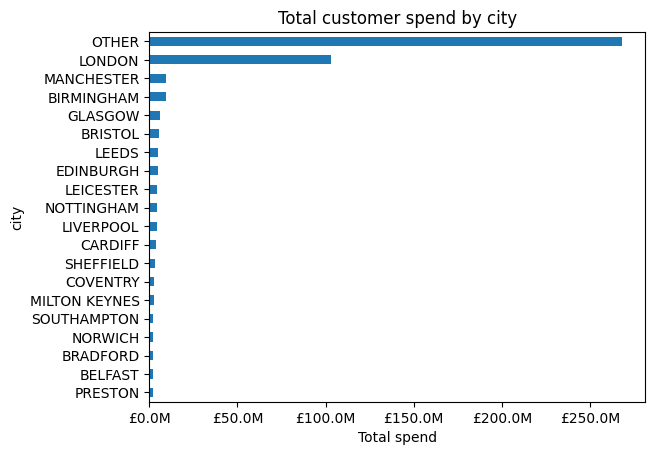

In [28]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# formatting numbers to be in millions rather than whole integers
# courtesy of this StackOverflow answer: https://stackoverflow.com/a/61330823/2039162
def millions(x, pos):
    return '£%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

fig, axis = plt.subplots()

top_20_spend = (
    customers
    .groupby("city")
    ["total_spend"].sum()
    .sort_values(ascending=False)
    .head(20)
    .sort_values(ascending=True)
)

top_20_spend.plot.barh(ax=axis)

axis.xaxis.set_major_formatter(formatter)
axis.set(
    title="Total customer spend by city",
    xlabel="Total spend"
)

plt.show()

Clearly the "Other" category takes a large share of the total customer spend, since it makes up over half our customers. A further iteration could focus on separating this category out further into towns  or regions for example.

Let's look at London vs. the rest of the country.

In [29]:
print("Total spend for London customers:")
print(customers.loc[customers["city"] == "LONDON", "total_spend"].sum())

Total spend for London customers:
103042800


In [30]:
print("Total spend outside London:")
print(customers.loc[customers["city"] != "LONDON", "total_spend"].sum())
print("Total spend outside London (excluding OTHER):")
print(customers.loc[customers["city"].isin(["LONDON", "OTHER"]) == False, "total_spend"].sum())

Total spend outside London:
387331300
Total spend outside London (excluding OTHER):
119468400


If we only compare large cities, London has generated £103m in sales, and all other cities **together** generated £119m. Our customers are definitely London-centric, with Manchester, Birmingham, and Glasgow seeing the largest spending outside of London. Those are the largest cities outside London by population too. Leeds should perhaps be higher based on population, but there is no reason our customer spend patterns should correlate perfectly to population.